In [21]:
#Importações

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

import joblib

from lightgbm import LGBMClassifier
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,  
    confusion_matrix,
    roc_auc_score,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score, 
    f1_score,
    accuracy_score,
    roc_curve
)

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
import kagglehub


In [22]:
#Importação do Dataset


try:
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    df = pd.read_csv(path + "/creditcard.csv")
    
except Exception as e:
    df = pd.read_csv("../data/creditcard.csv")

In [24]:
#Visão Geral do Dataset

count_class_0, count_class_1 = df['Class'].value_counts()

print(f"Dimensões do dataset: {df.shape}")
print(f"Distribuição das classes:\nClasse 0: {count_class_0}\nClasse 1: {count_class_1}")
print(f"Proporção de fraudes: {df['Class'].mean()*100:.2f}%")


Dimensões do dataset: (284807, 31)
Distribuição das classes:
Classe 0: 284315
Classe 1: 492
Proporção de fraudes: 0.17%


In [25]:
# Verificação de valores nulos
print(f"Valores nulos:\n{df.isnull().sum()}")

Valores nulos:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [26]:
#Verificação de valores duplicados
print(f"Valores duplicados: {df.duplicated().sum()}")

#Remoção dos valores duplicados
df.drop_duplicates(inplace=True)


Valores duplicados: 1081


In [27]:
#Novas dados após remoção de duplicados
count_class_0, count_class_1 = df['Class'].value_counts()

print(f"Dimensões do dataset: {df.shape}")
print(f"Distribuição das classes:\nClasse 0: {count_class_0}\nClasse 1: {count_class_1}")
print(f"Proporção de fraudes: {df['Class'].mean()*100:.2f}%")

Dimensões do dataset: (283726, 31)
Distribuição das classes:
Classe 0: 283253
Classe 1: 473
Proporção de fraudes: 0.17%


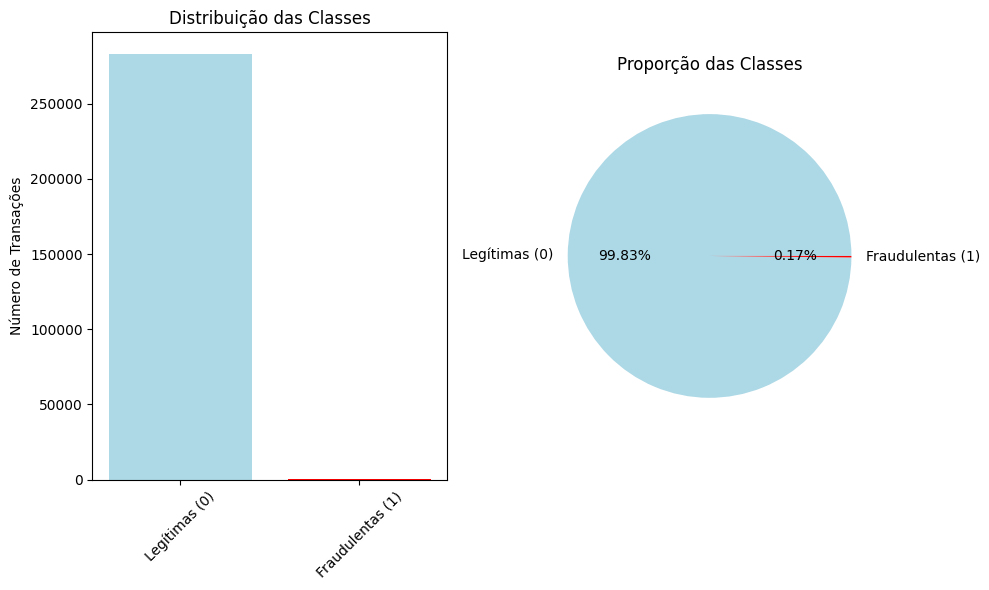

In [28]:
# Gráfico de distribuição das classes
plt.figure(figsize=(10, 6))
classes = ['Legítimas (0)', 'Fraudulentas (1)']
counts = [count_class_0, count_class_1]
colors = ['lightblue', 'red']

plt.subplot(1, 2, 1)
plt.bar(classes, counts, color=colors)
plt.title('Distribuição das Classes')
plt.ylabel('Número de Transações')
plt.xticks(rotation=45)

# Gráfico de distribuição das classes
plt.subplot(1, 2, 2)
plt.pie(counts, labels=classes, colors=colors, autopct='%1.2f%%')
plt.title('Proporção das Classes')
plt.tight_layout()
plt.show()


In [29]:
# Engenharia de Features
# Criando duas features Hour e Day baseado no Time em segundos
df['Time'] = df['Time'] / 3600
df['Hour'] = df['Time'] % 24
df['Day'] = (df['Time'] // 24)



In [30]:
#Estatisticas Descritivas
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,26.336410,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667,14.537139,0.491636
std,13.189180,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796,5.846094,0.499931
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000,0.000000,0.000000
25%,15.056875,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000,10.597500,0.000000
50%,23.525694,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000,15.008889,0.000000
75%,38.693889,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000,19.329167,1.000000
max,47.997778,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000,23.999444,1.000000


In [31]:
#Analise do Tempo

# Comparação entre classes
print("\nComparação por Classe - Valores (Tempo):")
time_by_class = df.groupby('Class')['Time'].agg(['mean', 'std', 'min', 'max'])
print(time_by_class)


Comparação por Classe - Valores (Tempo):
            mean        std       min        max
Class                                           
0      26.343072  13.187653  0.000000  47.997778
1      22.347365  13.510050  0.112778  47.318889


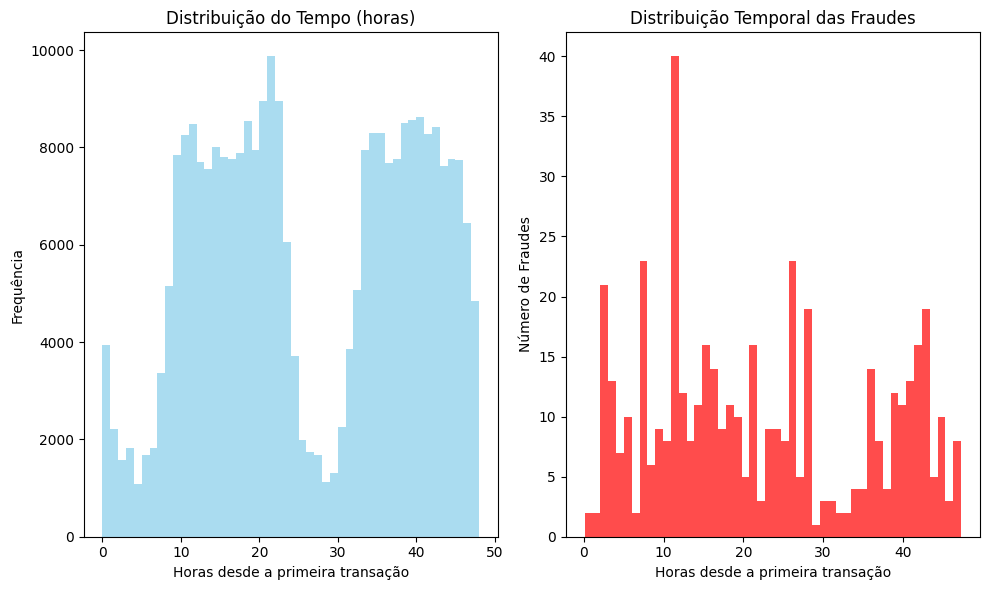

In [32]:
# Distribuição do tempo
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Time'], bins=48, alpha=0.7, color='skyblue')
plt.title('Distribuição do Tempo (horas)')
plt.xlabel('Horas desde a primeira transação')
plt.ylabel('Frequência')

# Tempo vs Fraudes
plt.subplot(1, 2, 2)
fraud_hours = df[df['Class'] == 1]['Time']
plt.hist(fraud_hours, bins=48, alpha=0.7, color='red')
plt.title('Distribuição Temporal das Fraudes')
plt.xlabel('Horas desde a primeira transação')
plt.ylabel('Número de Fraudes')


plt.tight_layout()
plt.show()



In [33]:
#Analise do Tempo por hora do dia

# Comparação entre classes
print("\nComparação por Classe - Valores (Tempo):")
time_by_class = df.groupby('Class')['Hour'].agg(['mean', 'std', 'min', 'max'])
print(time_by_class)


Comparação por Classe - Valores (Tempo):
            mean       std       min        max
Class                                          
0      14.541128  5.843972  0.000000  23.999444
1      12.148633  6.588707  0.112778  23.993333


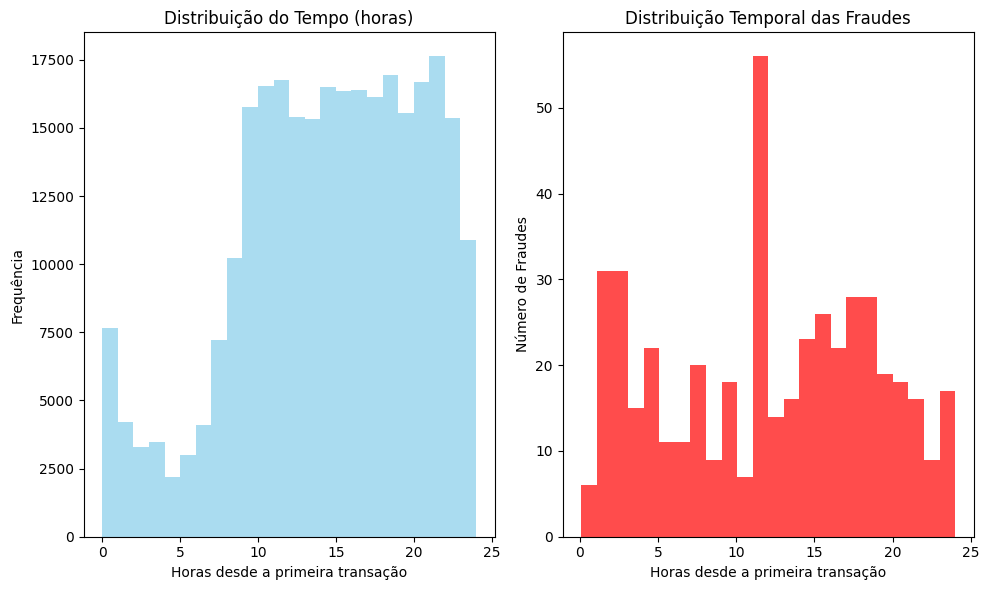

In [34]:
# Distribuição do tempo
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Hour'], bins=24, alpha=0.7, color='skyblue')
plt.title('Distribuição do Tempo (horas)')
plt.xlabel('Horas desde a primeira transação')
plt.ylabel('Frequência')

# Tempo vs Fraudes
plt.subplot(1, 2, 2)
fraud_hours = df[df['Class'] == 1]['Hour']
plt.hist(fraud_hours, bins=24, alpha=0.7, color='red')
plt.title('Distribuição Temporal das Fraudes')
plt.xlabel('Horas desde a primeira transação')
plt.ylabel('Número de Fraudes')


plt.tight_layout()
plt.show()


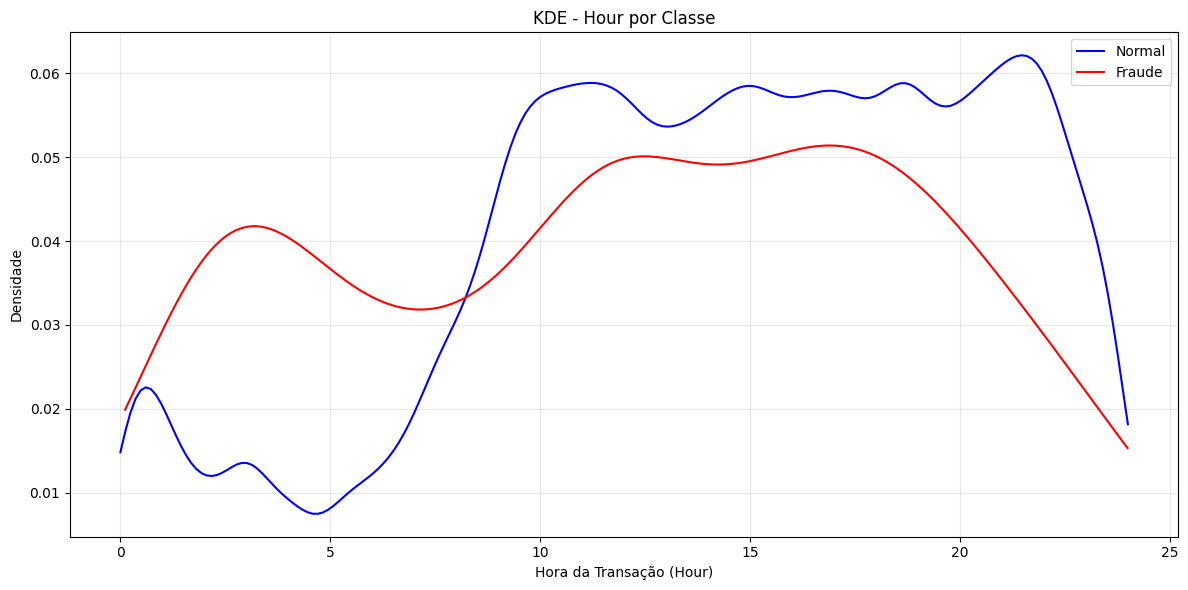

In [35]:
plt.figure(figsize=(12, 6))

sns.kdeplot(data=df[df['Class'] == 0], x='Hour', label='Normal', color='blue', 
            clip = (df[df['Class'] == 0]['Hour'].min(),
                    df[df['Class'] == 0]['Hour'].max()
            ))
sns.kdeplot(data=df[df['Class'] == 1], x='Hour', label='Fraude', color='red', 
            clip = (df[df['Class'] == 1]['Hour'].min(),
                    df[df['Class'] == 1]['Hour'].max()
            ))
plt.title('KDE - Hour por Classe')
plt.xlabel('Hora da Transação (Hour)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
fraud_by_hour = df[df['Class'] == 1].groupby('Hour').size()


# Análise de valores extremos
print("Análise de Valore Extremos:")
high_value_frauds = df[(df['Class'] == 1) & (df['Amount'] > df['Amount'].quantile(0.95))]
print(f"   Fraudes em transações de alto valor (> P95): {len(high_value_frauds)}")
if len(high_value_frauds) > 0:
    print(f"   Valor médio dessas fraudes: {high_value_frauds['Amount'].mean():.2f}")

# Padrões sazonais
print("Padrões Sazonais:")
df['DayPeriod'] = pd.cut(df['Hour'], 
                                bins=[0, 6, 12, 18, 24], 
                                labels=['Periodo 1', 'Periodo 2', 'Periodo 3', 'Periodo 4'])

fraud_by_period = df[df['Class'] == 1].groupby('DayPeriod').size()
if len(fraud_by_period) > 0:
    peak_fraud_period = fraud_by_period.idxmax()
    print(f"   Período com mais fraudes: {peak_fraud_period}")
    print(f"   Distribuição por período:")
    for period, count in fraud_by_period.items():
        print(f"     {period}: {count} fraudes")
        
df.drop('DayPeriod', axis=1, inplace=True)
df.drop('Day', axis=1, inplace=True)


Análise de Valore Extremos:
   Fraudes em transações de alto valor (> P95): 42
   Valor médio dessas fraudes: 816.16
Padrões Sazonais:
   Período com mais fraudes: Periodo 3
   Distribuição por período:
     Periodo 1: 115 fraudes
     Periodo 2: 118 fraudes
     Periodo 3: 133 fraudes
     Periodo 4: 107 fraudes


C:\Users\dfnas\AppData\Local\Temp\ipykernel_1724\3919303563.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_period = df[df['Class'] == 1].groupby('DayPeriod').size()


In [37]:
#Analise do Amount

# Comparação entre classes
print("\nComparação por Classe - Valores (Amount):")
amount_by_class = df.groupby('Class')['Amount'].agg(['mean', 'std', 'min', 'max'])
print(amount_by_class)


Comparação por Classe - Valores (Amount):
             mean         std  min       max
Class                                       
0       88.413575  250.379023  0.0  25691.16
1      123.871860  260.211041  0.0   2125.87


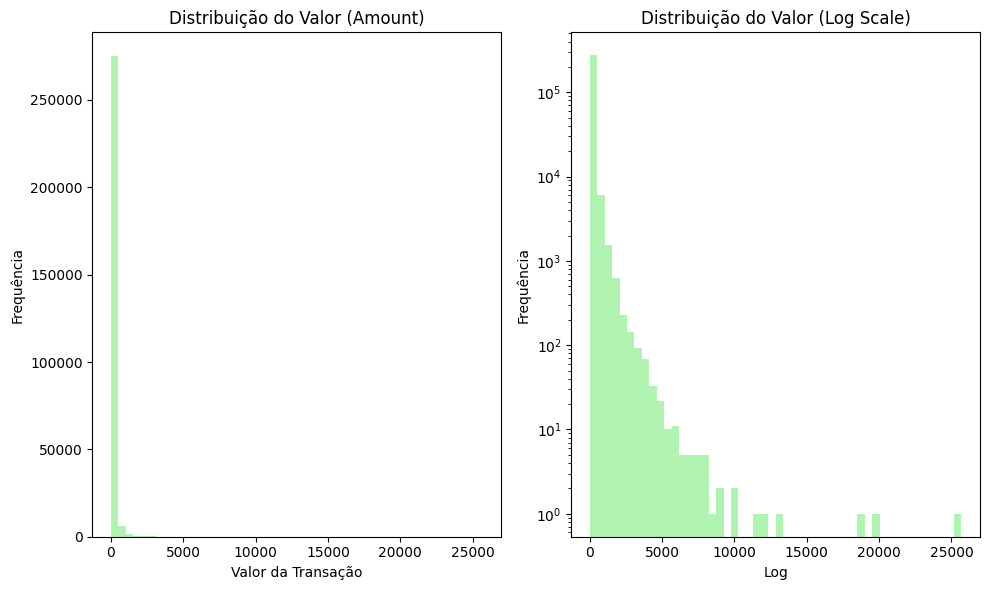

In [38]:
# Distribuição do Amount
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Amount'], bins=50, alpha=0.7, color='lightgreen')
plt.title('Distribuição do Valor (Amount)')
plt.xlabel('Valor da Transação')
plt.ylabel('Frequência')

# Distribuição do Amount em escala log
plt.subplot(1, 2, 2)
plt.hist(df['Amount'], bins=50, alpha=0.7, color='lightgreen')
plt.title('Distribuição do Valor (Log Scale)')
plt.xlabel('Log')
plt.ylabel('Frequência')
plt.yscale('log')


plt.tight_layout()
plt.show()


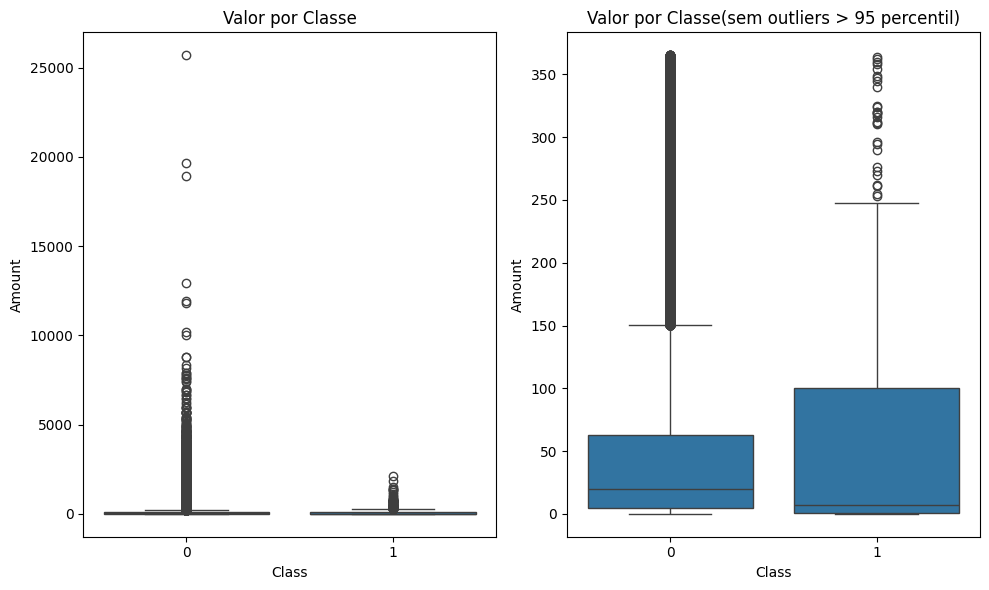

In [39]:
# Boxplot do Amount por classe
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Valor por Classe')

plt.subplot(1, 2, 2)
df_without_outliers = df[df['Amount'] < df['Amount'].quantile(0.95)]  # Remove outliers
sns.boxplot(x='Class', y='Amount', data=df_without_outliers)
plt.title('Valor por Classe(sem outliers > 95 percentil)')



plt.tight_layout()
plt.show()

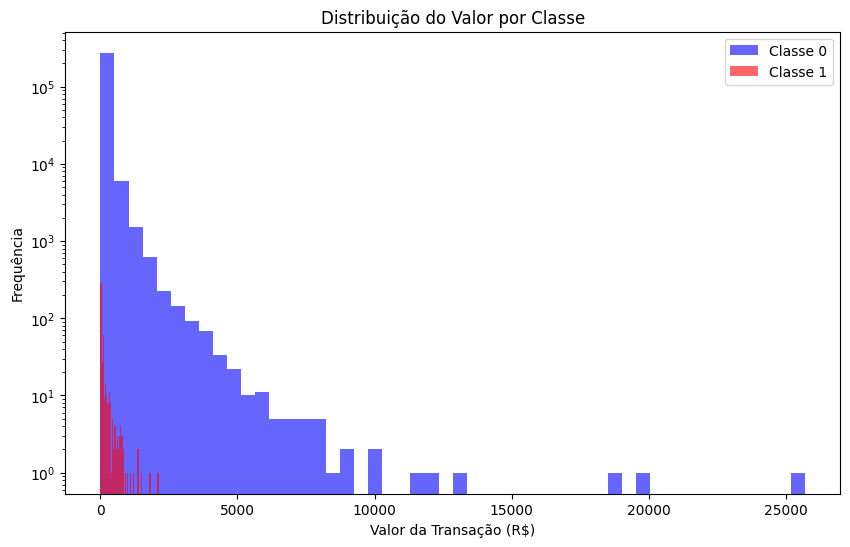

In [40]:
# Distribuição do Amount por classe
plt.figure(figsize=(10, 6))
for class_val, color in zip([0, 1], ['blue', 'red']):
    plt.hist(df[df['Class'] == class_val]['Amount'], 
             bins=50, alpha=0.6, label=f'Classe {class_val}', color=color)
plt.title('Distribuição do Valor por Classe')
plt.xlabel('Valor da Transação (R$)')
plt.ylabel('Frequência')
plt.legend()
plt.yscale('log')

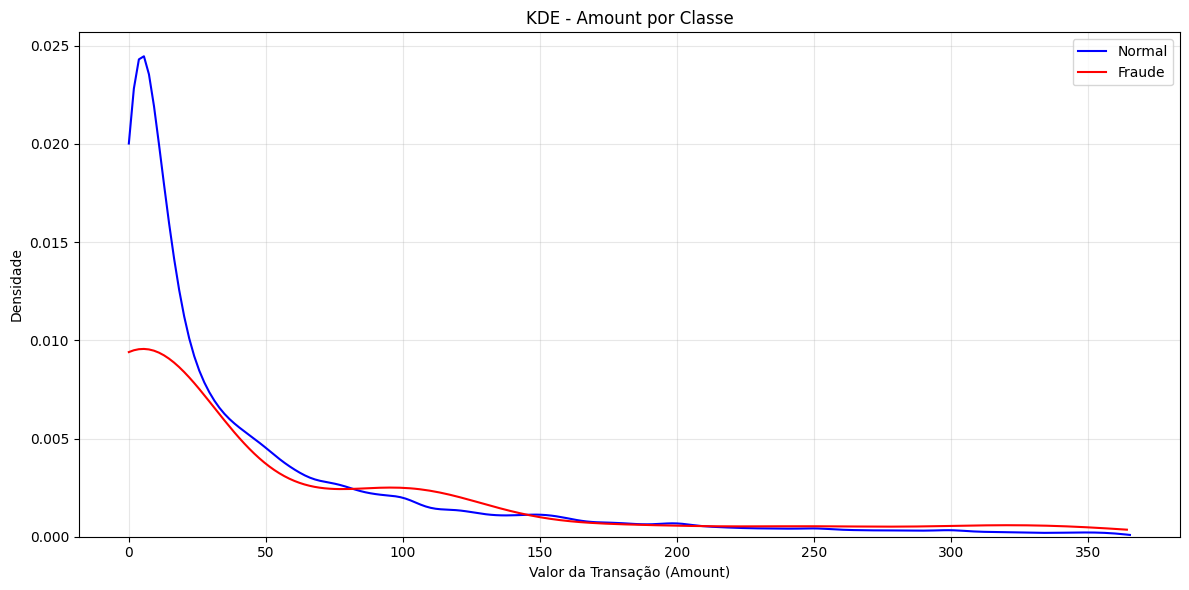

In [41]:
plt.figure(figsize=(12, 6))

sns.kdeplot(data=df_without_outliers[df_without_outliers['Class'] == 0], x='Amount', label='Normal', color='blue', 
            clip = (df_without_outliers[df_without_outliers['Class'] == 0]['Amount'].min(),
                    df_without_outliers[df_without_outliers['Class'] == 0]['Amount'].max()
            ))
sns.kdeplot(data=df_without_outliers[df_without_outliers['Class'] == 1], x='Amount', label='Fraude', color='red', 
            clip = (df_without_outliers[df_without_outliers['Class'] == 1]['Amount'].min(),
                    df_without_outliers[df_without_outliers['Class'] == 1]['Amount'].max()
            ))
plt.title('KDE - Amount por Classe')
plt.xlabel('Valor da Transação (Amount)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:

# Selecionando apenas os componentes V1-V28
pca_columns = [f'V{i}' for i in range(1, 29)]
pca_data = df[pca_columns]

print("Estatísticas dos componentes PCA:")
print(pca_data.describe())

# Verificando se os componentes estão normalizados
print(f"\nMédias aproximadas dos componentes V1-V28:")
print(f"Média geral: {pca_data.mean().mean():.6f}")
print(f"Desvio padrão geral: {pca_data.std().mean():.6f}")



Estatísticas dos componentes PCA:
                  V1             V2             V3             V4  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean        0.005917      -0.004135       0.001613      -0.002966   
std         1.948026       1.646703       1.508682       1.414184   
min       -56.407510     -72.715728     -48.325589      -5.683171   
25%        -0.915951      -0.600321      -0.889682      -0.850134   
50%         0.020384       0.063949       0.179963      -0.022248   
75%         1.316068       0.800283       1.026960       0.739647   
max         2.454930      22.057729       9.382558      16.875344   

                  V5             V6             V7             V8  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean        0.001828      -0.001139       0.001801      -0.000854   
std         1.377008       1.331931       1.227664       1.179054   
min      -113.743307     -26.160506     -43.557242     -73.216718   

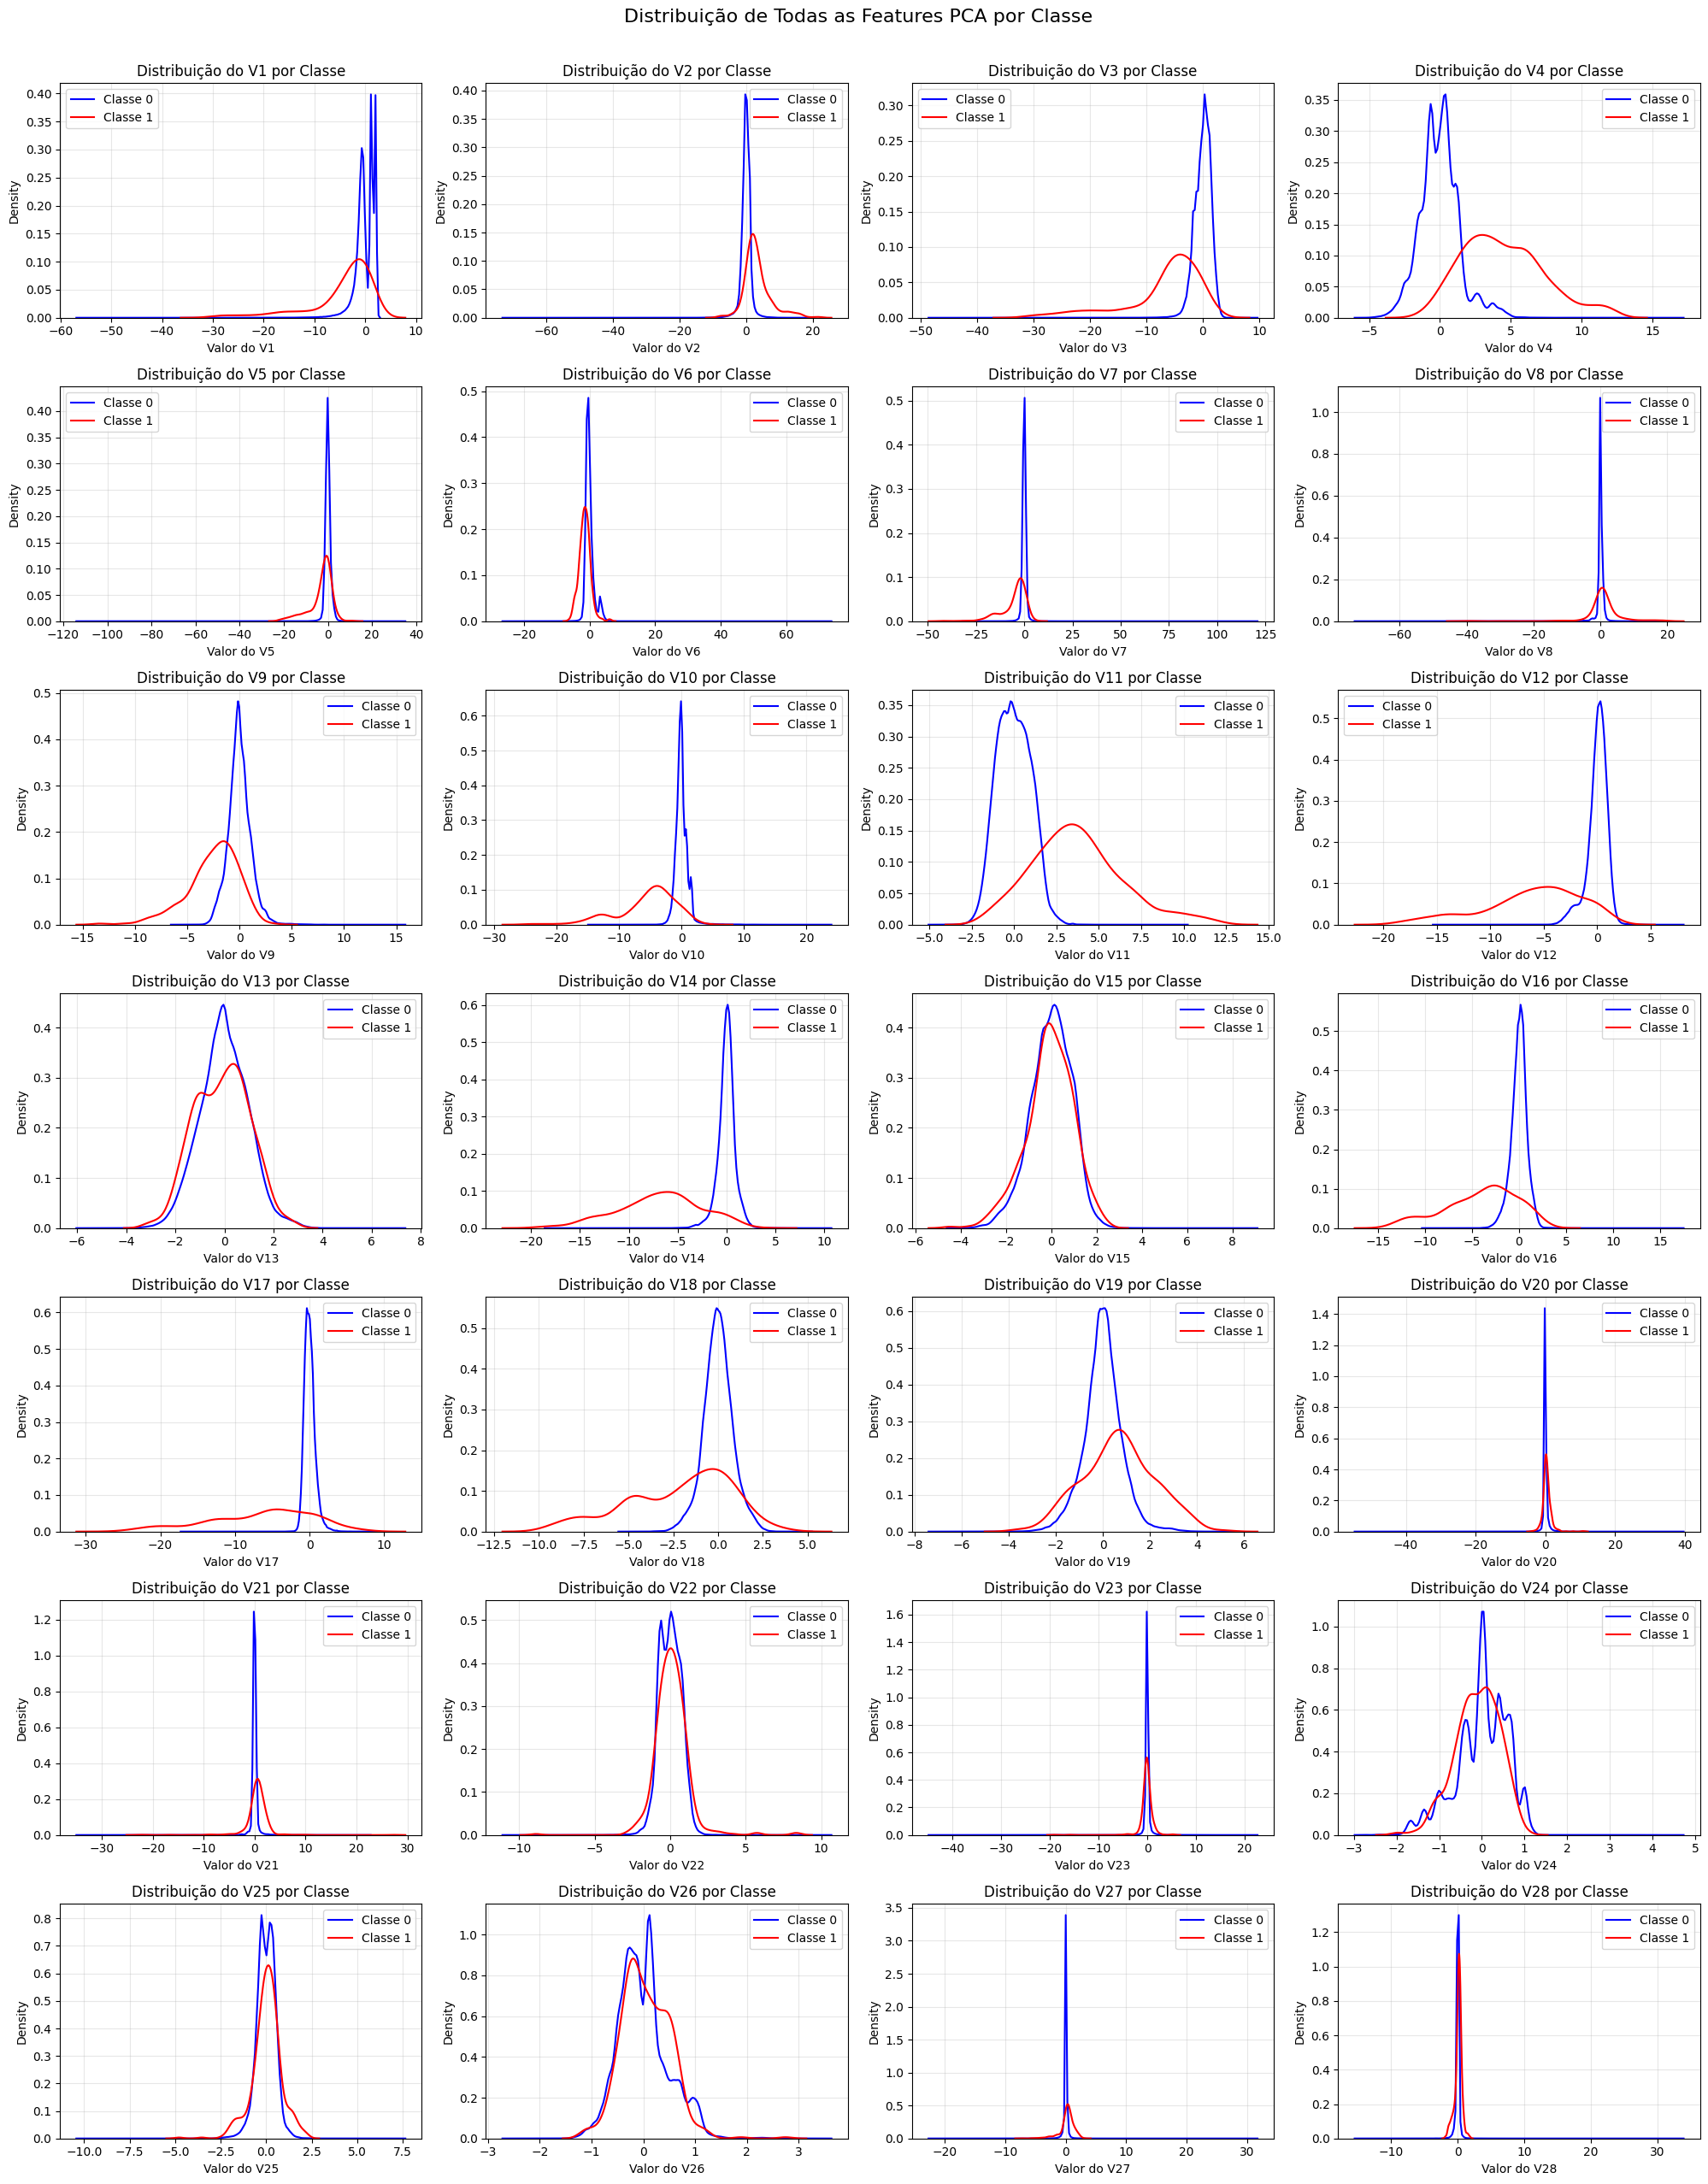

In [43]:
#Analise das features geradas por PCA

#Criar figura com subplots para todas as 28 features
fig, axes = plt.subplots(7, 4, figsize=(20, 25))
axes = axes.ravel()  

# Plotar KDE para cada feature V1 até V28
for i in range(1, 29):
    feature_name = f'V{i}'
    
    for class_val, color in zip([0, 1], ['blue', 'red']):
        sns.kdeplot(df[df['Class'] == class_val][feature_name], 
                    label=f'Classe {class_val}', 
                    color=color, 
                    ax=axes[i-1])
    
    axes[i-1].set_title(f'Distribuição do {feature_name} por Classe', fontsize=12)
    axes[i-1].set_xlabel(f'Valor do {feature_name}', fontsize=10)
    axes[i-1].legend()
    axes[i-1].grid(True, alpha=0.3)

# Remover axes vazios se houver
for j in range(28, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribuição de Todas as Features PCA por Classe', 
             fontsize=16, y=1.02)
plt.show()

In [44]:
# Matriz de correlação com a target
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)
correlation_with_target = correlation_with_target[correlation_with_target.index != 'Class']

print("Top 10 features mais correlacionadas com FRAUDE:")
for feature, corr in correlation_with_target.head(10).items():
    print(f"  {feature}: {corr:+.4f}")

print("\nTop 10 features menos correlacionadas com FRAUDE:")
for feature, corr in correlation_with_target.tail(10).items():
    print(f"  {feature}: {corr:+.4f}")


Top 10 features mais correlacionadas com FRAUDE:
  V11: +0.1491
  V4: +0.1293
  V2: +0.0846
  V19: +0.0336
  V8: +0.0331
  V21: +0.0264
  V27: +0.0219
  V20: +0.0215
  V28: +0.0097
  Amount: +0.0058

Top 10 features menos correlacionadas com FRAUDE:
  V9: -0.0940
  V1: -0.0945
  V18: -0.1053
  V7: -0.1723
  V3: -0.1823
  V16: -0.1872
  V10: -0.2070
  V12: -0.2507
  V14: -0.2934
  V17: -0.3135


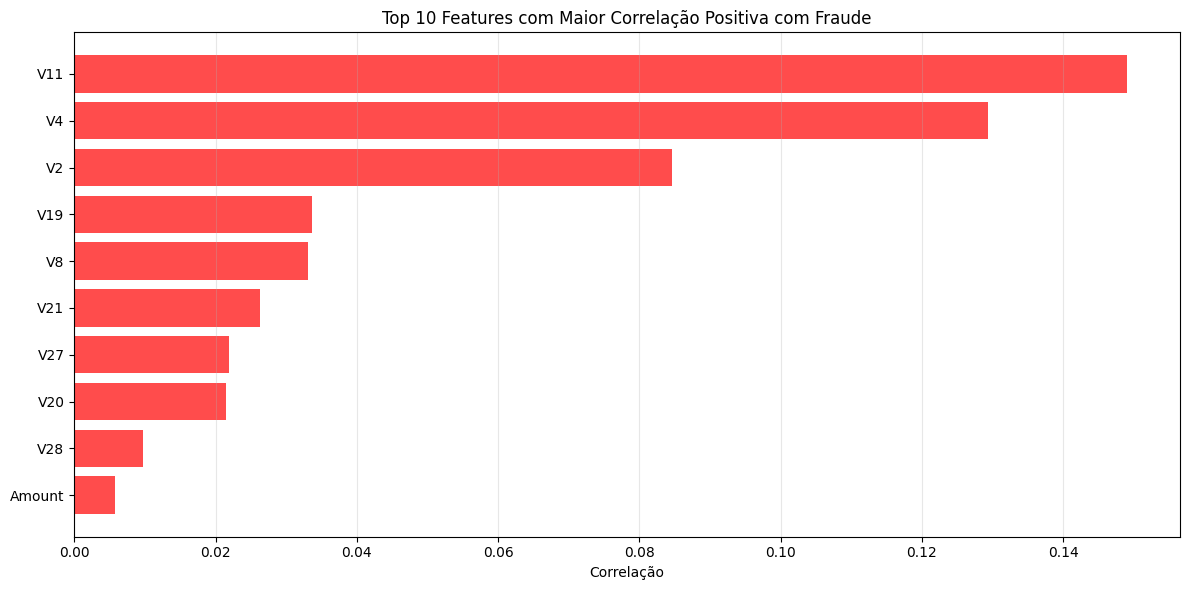

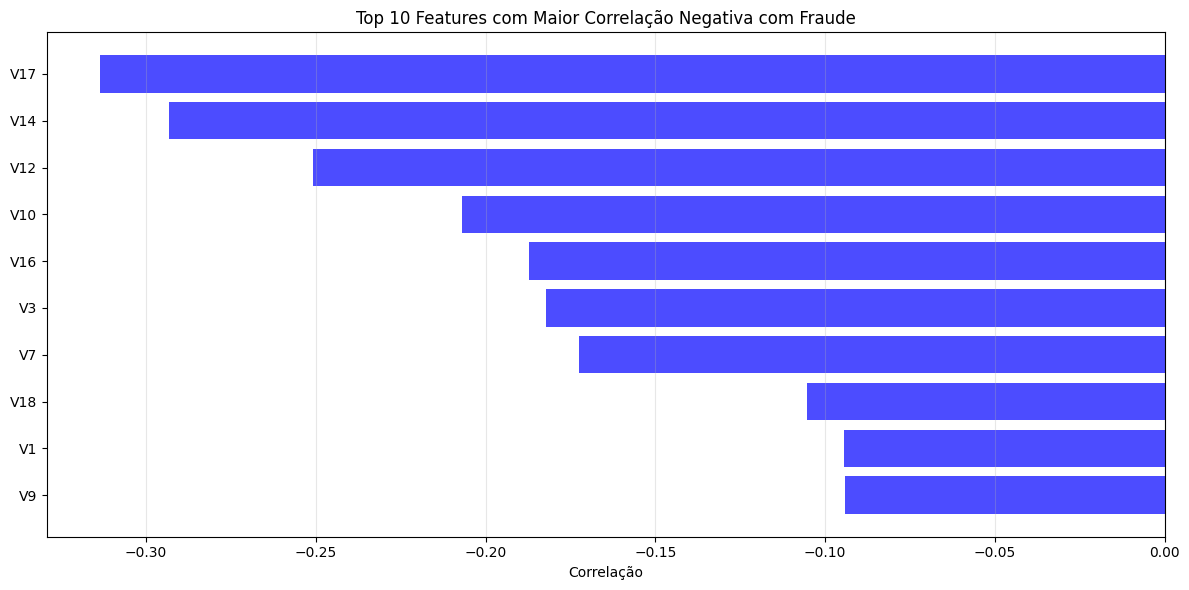

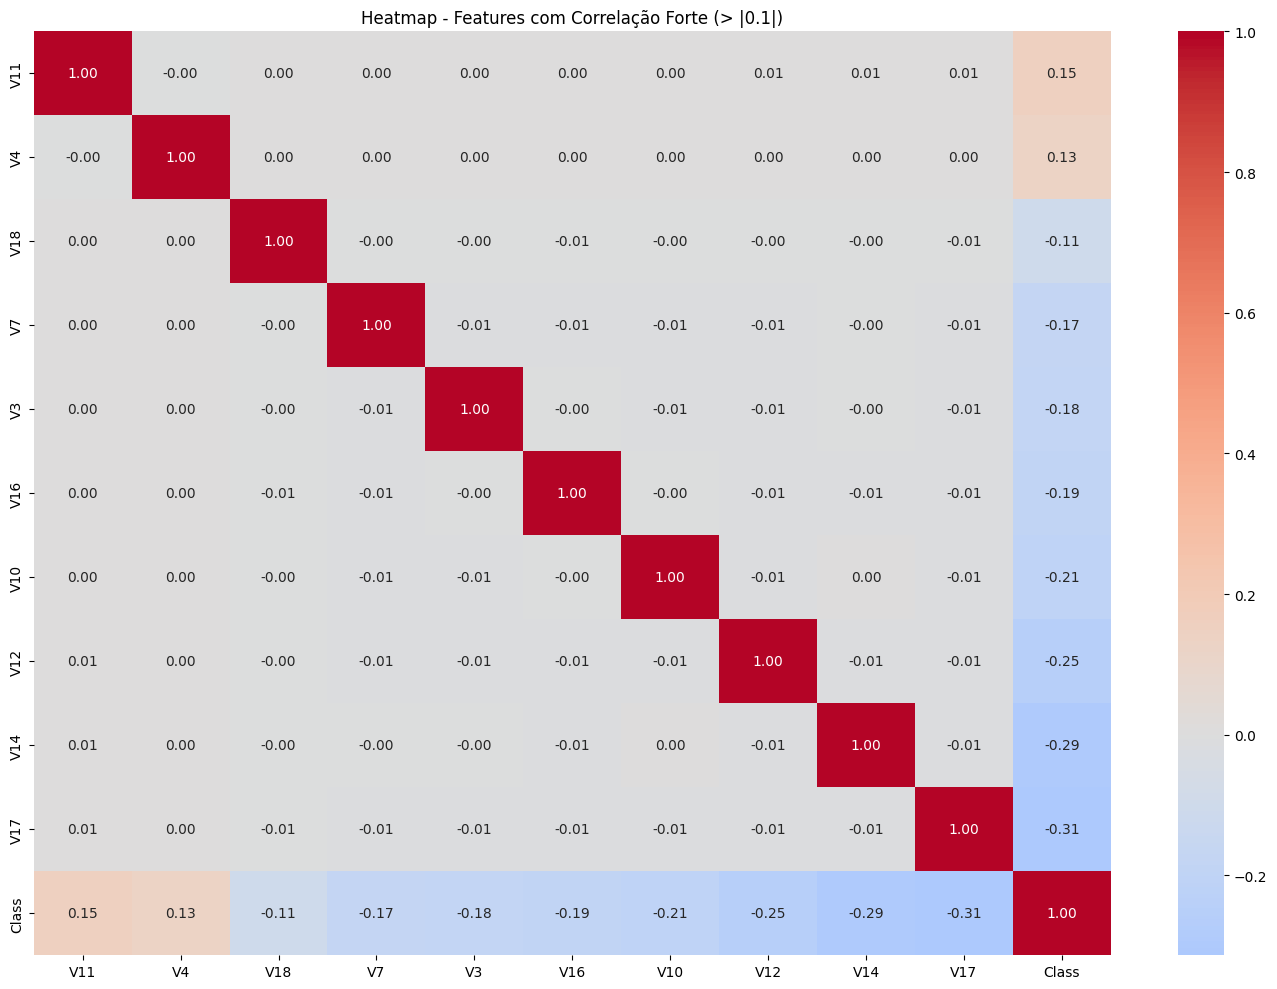

In [45]:
# Correlações Positivas
plt.figure(figsize=(12, 6))
top_features = correlation_with_target.head(10)[::-1]
plt.barh(range(len(top_features)), top_features.values, color='red', alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlação')
plt.title('Top 10 Features com Maior Correlação Positiva com Fraude', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Correlações Negativas
plt.figure(figsize=(12, 6))
bottom_features = correlation_with_target.tail(10)
plt.barh(range(len(bottom_features)), bottom_features.values, color='blue', alpha=0.7)
plt.yticks(range(len(bottom_features)), bottom_features.index)
plt.xlabel('Correlação')
plt.title('Top 10 Features com Maior Correlação Negativa com Fraude', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(14, 10))
strong_corr_features = correlation_with_target[
    (correlation_with_target > 0.1) | (correlation_with_target < -0.1)
].index.tolist()

if len(strong_corr_features) > 0:
    strong_corr_matrix = df[strong_corr_features + ['Class']].corr()
    sns.heatmap(strong_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Heatmap - Features com Correlação Forte (> |0.1|)', fontsize=12)
    plt.tight_layout()
    plt.show()

Pré Processamento

In [46]:
# Separar features e target
X = df.drop('Class', axis=1)
y = df['Class']


#Seleção de Features apenas com corelação > |0,1|

#V11: +0.1491
#V4: +0.1293
#V18: -0.1053
#V7: -0.1723
#V3: -0.1823
#V16: -0.1872
#V10: -0.2070
#V12: -0.2507
#V14: -0.2934
#V17: -0.3135

X = df[['V11', 'V4', 'V18', 'V7', 'V3', 'V16', 'V10', 'V12', 'V14', 'V17', 'Amount', 'Hour']]




In [47]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


#Normalizar apenas a Feature Amount e Hour

scaler = RobustScaler()

X_train[['Amount', 'Hour']] = scaler.fit_transform(X_train[['Amount', 'Hour']])

X_test[['Amount', 'Hour']] = scaler.transform(X_test[['Amount', 'Hour']])

X_train.describe()


,V11,V4,V18,V7,V3,V16,V10,V12,V14,V17,Amount,Hour
count,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000,198608.000000
mean,-0.000976,0.000167,0.002147,0.001579,0.002225,0.001792,-0.001279,-0.000628,-0.000863,-0.001112,0.919896,-0.053952
std,1.019369,1.419313,0.836651,1.198614,1.506249,0.873177,1.072300,0.993239,0.954925,0.842606,3.369163,0.668329
min,-4.797473,-5.683171,-9.498746,-43.557242,-33.680984,-14.129855,-24.588262,-18.553697,-19.214325,-25.162799,-0.306624,-1.718378
25%,-0.763007,-0.849299,-0.498260,-0.552417,-0.887008,-0.466011,-0.534169,-0.405237,-0.427282,-0.484100,-0.227468,-0.505226
50%,-0.032512,-0.021783,-0.000728,0.041112,0.177689,0.069176,-0.093569,0.137819,0.048826,-0.065560,0.000000,0.000000
75%,0.739536,0.744018,0.502384,0.572347,1.026722,0.523658,0.455951,0.615491,0.491024,0.396436,0.772532,0.494774
max,12.018913,16.875344,4.712398,34.303177,9.382558,7.059132,23.745136,7.848392,10.526766,8.538195,262.295792,1.028318


Modelagem

In [ ]:
def kfold_training(model, X, y, n_splits=5, use_smote=False, random_state=42):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    auprc_scores = []
    
    if use_smote:
        smote = SMOTE(random_state=random_state)
    
    print(f"=== Iniciando {n_splits}-Fold Cross Validation ===")
    
    if hasattr(X, 'values'):
        feature_names = X.columns.tolist()
        X_df = X
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        X_df = pd.DataFrame(X, columns=feature_names)
    
    y_array = y.values if hasattr(y, 'values') else y
    
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_df, y_array), 1):

        X_train_fold, X_val_fold = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]

        
        # Aplicar SMOTE se solicitado
        if use_smote:
            # SMOTE trabalha com arrays, mas converter de volta para DataFrame
            X_train_fold_np, y_train_fold = smote.fit_resample(X_train_fold.values, y_train_fold)
            X_train_fold = pd.DataFrame(X_train_fold_np, columns=feature_names)
            print(f"Fold {fold}: Distribuição após SMOTE - {np.bincount(y_train_fold)}")

        model.fit(X_train_fold, y_train_fold)
        
        y_scores = model.predict_proba(X_val_fold)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val_fold, y_scores)
        auprc = auc(recall, precision)
        auprc_scores.append(auprc)
        
        print(f"Fold {fold}: AUPRC = {auprc:.4f}")

    
    print(f"\nResultado Final:")
    print(f"AUPRC Médio: {np.mean(auprc_scores):.4f} (+/- {np.std(auprc_scores):.4f})")
    
    return auprc_scores, model

In [49]:
def evaluate_model(model, X_test, y_test, model_name):

    y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
    
    if hasattr(model, 'feature_names_in_'):
        
        if hasattr(X_test, 'columns'):
            if list(X_test.columns) == list(model.feature_names_in_):
                # Ordem correta
                X_test_processed = X_test
            else:
                # Reordenar features
                X_test_processed = X_test[model.feature_names_in_]
        else:
            # X_test é numpy array - converter para DataFrame
            X_test_processed = pd.DataFrame(X_test, columns=model.feature_names_in_)
    else:
        # Modelo não tem feature names - usar numpy array
        X_test_processed = X_test.values if hasattr(X_test, 'values') else X_test
    
    # Fazer predições
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Calcular métricas
    precision, recall, _ = precision_recall_curve(y_test_array, y_pred_proba)
    auprc = auc(recall, precision)
    avg_precision = average_precision_score(y_test_array, y_pred_proba)
    
    print(f"\n=== {model_name} ===")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_array, y_pred))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test_array, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()
    
    return auprc, avg_precision

=== Iniciando 5-Fold Cross Validation ===
Fold 1: Distribuição após SMOTE - [158621 158621]
Fold 1: AUPRC = 0.6776
Fold 2: Distribuição após SMOTE - [158621 158621]
Fold 2: AUPRC = 0.7233
Fold 3: Distribuição após SMOTE - [158622 158622]
Fold 3: AUPRC = 0.6988
Fold 4: Distribuição após SMOTE - [158622 158622]
Fold 4: AUPRC = 0.7773
Fold 5: Distribuição após SMOTE - [158622 158622]
Fold 5: AUPRC = 0.7633

Resultado Final:
AUPRC Médio: 0.7281 (+/- 0.0377)

=== Logistic Regression (K-Fold + SMOTE) ===
AUPRC: 0.6076
Average Precision: 0.6059

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.87      0.09       142

    accuracy                           0.97     85118
   macro avg       0.52      0.92      0.54     85118
weighted avg       1.00      0.97      0.98     85118



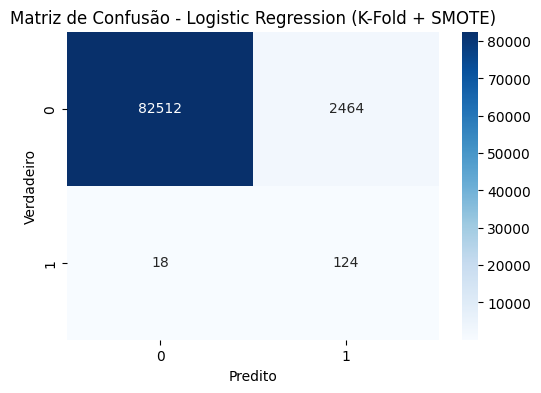

In [50]:
lr_kfold = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, C=0.1)


auprc_scores, lr_trained = kfold_training(
    model=lr_kfold,
    X=X_train,  
    y=y_train,  
    n_splits=5,
    use_smote=True,
    random_state=42
)
auprc_final, ap_final = evaluate_model(lr_trained, X_test, y_test, "Logistic Regression (K-Fold + SMOTE)")

=== Iniciando 5-Fold Cross Validation ===
Fold 1: AUPRC = 0.7998
Fold 2: AUPRC = 0.8668
Fold 3: AUPRC = 0.7874
Fold 4: AUPRC = 0.8524
Fold 5: AUPRC = 0.8590

Resultado Final:
AUPRC Médio: 0.8331 (+/- 0.0328)

=== XGBoost (K-Fold) ===
AUPRC: 0.7963
Average Precision: 0.7965

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.89      0.76      0.82       142

    accuracy                           1.00     85118
   macro avg       0.94      0.88      0.91     85118
weighted avg       1.00      1.00      1.00     85118



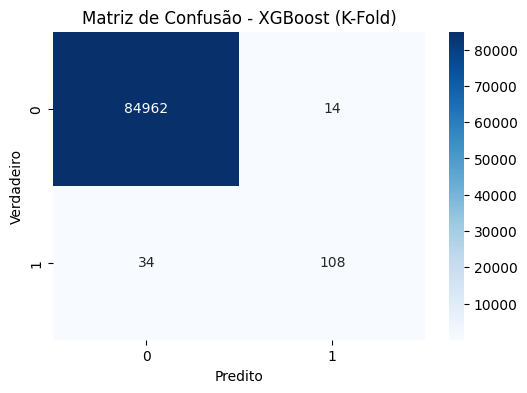

In [51]:
# XGBoost com scale_pos_weight
scale_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_ratio,
    eval_metric='logloss'
)

auprc_scores, xgb_trained = kfold_training(
    model=xgb,
    X=X_train,  
    y=y_train,  
    n_splits=5,
    use_smote=False,
    random_state=42
)
auprc_final, ap_final = evaluate_model(xgb_trained, X_test, y_test, "XGBoost (K-Fold)")

=== Iniciando 5-Fold Cross Validation ===
Fold 1: AUPRC = 0.7590
Fold 2: AUPRC = 0.8662
Fold 3: AUPRC = 0.8043
Fold 4: AUPRC = 0.8540
Fold 5: AUPRC = 0.8413

Resultado Final:
AUPRC Médio: 0.8250 (+/- 0.0389)

=== Random Forest (K-Fold) ===
AUPRC: 0.7833
Average Precision: 0.7838

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.85      0.77      0.81       142

    accuracy                           1.00     85118
   macro avg       0.93      0.88      0.90     85118
weighted avg       1.00      1.00      1.00     85118



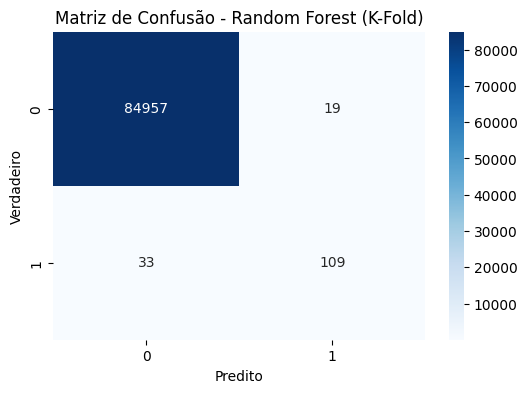

In [52]:
#Random Forest com Kfold

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

auprc_scores, rf_trained = kfold_training(
    model=rf,
    X=X_train,  
    y=y_train,  
    n_splits=5,
    use_smote=False,
    random_state=42
)
auprc_final, ap_final = evaluate_model(rf_trained, X_test, y_test, "Random Forest (K-Fold)")

=== Iniciando 5-Fold Cross Validation ===
Fold 1: AUPRC = 0.4594
Fold 2: AUPRC = 0.4626
Fold 3: AUPRC = 0.4362
Fold 4: AUPRC = 0.4689
Fold 5: AUPRC = 0.4522

Resultado Final:
AUPRC Médio: 0.4559 (+/- 0.0112)

=== LightGBM (K-Fold) ===
AUPRC: 0.4347
Average Precision: 0.0350

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     84976
           1       0.04      0.83      0.07       142

    accuracy                           0.97     85118
   macro avg       0.52      0.90      0.53     85118
weighted avg       1.00      0.97      0.98     85118



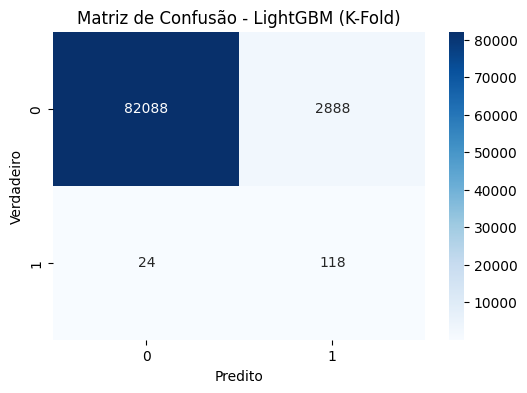

In [53]:
#LightGBM com Kfold

lgbm = LGBMClassifier(
    scale_pos_weight=scale_ratio,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    metric='average_precision',
    n_jobs=-1,
    verbosity=-1
)

auprc_scores, lgbm_trained = kfold_training(
    model=lgbm,
    X=X_train,  
    y=y_train,  
    n_splits=5,
    use_smote=False,
    random_state=42
)
auprc_final, ap_final = evaluate_model(lgbm_trained, X_test, y_test, "LightGBM (K-Fold)")

In [ ]:
#SVM (Linear) com Kfold e SMOTE

svm = SVC(
    kernel='linear',
    class_weight='balanced',
    probability=True,
    random_state=42,
    C=0.1
)

auprc_scores, svm_trained = kfold_training(
    model=svm,
    X=X_train,  
    y=y_train,  
    n_splits=5,
    use_smote=True,
    random_state=42
)
auprc_final, ap_final = evaluate_model(lgbm_trained, X_test, y_test, "SVM (K-Fold + SMOTE)")

=== Iniciando 5-Fold Cross Validation ===
Fold 1: Distribuição após SMOTE - [158621 158621]


Otimização de Hiperparametros

In [ ]:
#Otimizando Random Forest

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

rf = RandomForestClassifier(random_state=42, class_weight='balanced',  n_jobs=-1)

# Espaço de parâmetros para Random Forest
rf_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]              
}


rf_grid_search = GridSearchCV(
    rf,
    rf_param_dist,
    scoring=auprc_scorer,  
    cv=3,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("Iniciando Grid Search para Random Forest...")
rf_grid_search.fit(X_train, y_train)

print("\nMelhores Parâmentros - Random Forest:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Melhor AUPRC : {rf_grid.best_score_:.4f}")

best_rf = rf_grid.best_estimator_

evaluate_model(best_rf, X_test, y_test, "Random Forest Otimizado")

Iniciando Grid Search para Random Forest...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


In [44]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 14,
 'n_estimators': 120}

In [ ]:
# Otimizando XGBoost

xgb = XGBClassifier(random_state=42, scale_pos_weight=scale_ratio, eval_metric='logloss', n_jobs=-1)

# Espaço de parâmetros para XGBoost
xgb_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    scoring=auprc_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

print("Iniciando Grid Search para XGBoost...")
xgb_grid_search.fit(X_train, y_train)

print("\nMelhores Parâmentros -XGBoost:")
for param, value in xgb_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Melhor AUPRC : {xgb_grid.best_score_:.4f}")

best_xgb = xgb_grid_search.best_estimator_

evaluate_model(best_xgb, X_test, y_test, "XGBoost Otimizado")


In [ ]:
Salvando melhor modelo

In [54]:
joblib.dump(rf_trained, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')


['../models/scaler.pkl']